<a href="https://colab.research.google.com/github/RAvila-bioeng/DeepLearningModel_Evaluation/blob/main/DeepLearningModel_optimizado_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import kagglehub
import tensorflow as tf
from tensorflow.keras.layers import (Dense, Conv2D, MaxPooling2D, Dropout,
    BatchNormalization, Conv2DTranspose, Activation, concatenate, Input)
from tensorflow.keras import Model
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import os
import pandas as pd
import time
from google.colab import drive
import gc

En primer lugar Conectamos tu Google Drive al entorno de Colab, ya que esto nos permite guardar resultados, modelos entrenados, etc.

Y ademas vita perder datos cuando se reinicia la sesión.

In [ ]:
drive.mount('/content/drive')
SAVE_DIR = "/content/drive/MyDrive/unet_experimentos"
os.makedirs(SAVE_DIR, exist_ok=True)

print("Guardando resultados en:", SAVE_DIR)
download_path = kagglehub.dataset_download(
    "nikitamanaenkov/fundus-image-dataset-for-vessel-segmentation"
)
print("Dataset descargado en:", download_path)

Mounted at /content/drive
Guardando resultados en: /content/drive/MyDrive/unet_experimentos
Using Colab cache for faster access to the 'fundus-image-dataset-for-vessel-segmentation' dataset.
Dataset descargado en: /kaggle/input/fundus-image-dataset-for-vessel-segmentation


Definimos la siguiente funcion que lo que hace es implementa un bloque típico de CNN compuesto por:

- Convolución 2D
- Normalización por lotes
- Activación (ReLU por defecto)
- Dropout (opcional)
- MaxPooling (reducción de dimensión)

Es importante porque:

- Agrupa operaciones repetitivas en una función modular.
- Facilita construir modelos más complejos y profundos.
- Mejora la estabilidad del entrenamiento gracias a BatchNorm.
- Dropout añade regularización para reducir el overfitting.
- MaxPooling permite capturar características más abstractas y reducir el coste computacional.

In [ ]:
def conv_block(input_tensor, filters, kernel_size=3, activation="relu",
               batch_norm=True, dropout_rate=0.0):

    x = Conv2D(filters, kernel_size, padding="same")(input_tensor)
    if batch_norm:
        x = BatchNormalization()(x)
    x = Activation(activation)(x)

    x = Conv2D(filters, kernel_size, padding="same")(x)
    if batch_norm:
        x = BatchNormalization()(x)
    x = Activation(activation)(x)

    if dropout_rate > 0:
        x = Dropout(dropout_rate)(x)

    return x


def encoder_block(input_tensor, filters, **kwargs):
    x = conv_block(input_tensor, filters, **kwargs)
    p = MaxPooling2D((2, 2))(x)
    return x, p


def decoder_block(input_tensor, skip_tensor, filters, **kwargs):
    x = Conv2DTranspose(filters, 2, strides=2, padding="same")(input_tensor)
    x = concatenate([x, skip_tensor])
    x = conv_block(x, filters, **kwargs)
    return x

Seguimos definiendo funciones que nos permiten construir una arquitectura completa de segmentación basada en múltiples conv_block.

Define:

- Capa de entrada
- Mapa de características progresivamente más profundo
- Capa de salida con activación sigmoide (típico en segmentación binaria)

Todo esto es necesario para generar máscaras pixel a pixel.Esta estructura facilita pruebas con distintos tamaños y configuraciones.

Y por último la activación sigmoide es necesaria para obtener valores entre 0 y 1 en la predicción final.

In [ ]:
def build_model(img_size=(512, 512),
                filters_first_layer=64,
                activation="relu",
                kernel_size=3,
                batch_norm=True,
                dropout_rate=0.0,
                unet_depth=4):
    """
    Misma arquitectura que el notebook original:
    4 bloques de encoder, bottleneck, 4 bloques de decoder.
    Solo hacemos algunos parámetros configurables.
    (El parámetro unet_depth se deja para compatibilidad,
    pero aquí usamos profundidad fija 4).
    """
    inp = Input(shape=(*img_size, 3))

    # --- Encoder ---
    x1, p1 = encoder_block(
        inp,
        filters_first_layer,
        activation=activation,
        kernel_size=kernel_size,
        batch_norm=batch_norm,
        dropout_rate=dropout_rate
    )

    x2, p2 = encoder_block(
        p1,
        filters_first_layer * 2,
        activation=activation,
        kernel_size=kernel_size,
        batch_norm=batch_norm,
        dropout_rate=dropout_rate
    )

    x3, p3 = encoder_block(
        p2,
        filters_first_layer * 4,
        activation=activation,
        kernel_size=kernel_size,
        batch_norm=batch_norm,
        dropout_rate=dropout_rate
    )

    x4, p4 = encoder_block(
        p3,
        filters_first_layer * 8,
        activation=activation,
        kernel_size=kernel_size,
        batch_norm=batch_norm,
        dropout_rate=dropout_rate
    )

    # --- Bottleneck ---
    b = conv_block(
        p4,
        filters_first_layer * 16,
        activation=activation,
        kernel_size=kernel_size,
        batch_norm=batch_norm,
        dropout_rate=dropout_rate
    )

    # --- Decoder ---
    d1 = decoder_block(
        b, x4,
        filters_first_layer * 8,
        activation=activation,
        kernel_size=kernel_size,
        batch_norm=batch_norm,
        dropout_rate=dropout_rate
    )

    d2 = decoder_block(
        d1, x3,
        filters_first_layer * 4,
        activation=activation,
        kernel_size=kernel_size,
        batch_norm=batch_norm,
        dropout_rate=dropout_rate
    )

    d3 = decoder_block(
        d2, x2,
        filters_first_layer * 2,
        activation=activation,
        kernel_size=kernel_size,
        batch_norm=batch_norm,
        dropout_rate=dropout_rate
    )

    d4 = decoder_block(
        d3, x1,
        filters_first_layer,
        activation=activation,
        kernel_size=kernel_size,
        batch_norm=batch_norm,
        dropout_rate=dropout_rate
    )

    out = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)
    model = Model(inp, out)

    return model



Ahora, simplemente generamos un ejemplar del modelo para comprobar que compila correctamente.

Asi de esta forma podemos detectar errores antes de hacer el entrenamiento real. También aseguramos que las dismensiones de entrada y de salida son validas.

In [ ]:
test_model = build_model()
print("Modelo creado:", test_model is not None)
test_model.summary()


Modelo creado: True


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 512, 512,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 512, 512,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 512, 512,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 512, 512,  │     36,928 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 512,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 512, 512,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 256, 256,  │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 256, 256,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 256, 256,  │    147,584 │ activation_2[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 128, 128,  │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 128, 128,  │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │      1,024 │ conv2d_4[0][0]  

 Total params: 31,055,297 (118.47 MB)

 Trainable params: 31,043,521 (118.42 MB)

 Non-trainable params: 11,776 (46.00 KB)

Continuamos con esta funcion que recorre las carpetas de imeagnes y mascaras, lee los archivos, loc oconvierte a tamaño deseado y lo normaliza.

Todo esto garantiza que las imagenes tnegan el mismo tamaño, algo que es un requisito obligatorio para las redes convolucioneales. Además reducimos el trabajo de preparación de datos.

In [ ]:
def load_data(path, img_size=(512, 512), num_images=100):
    images, masks = [], []

    originals = sorted(os.listdir(path + "/Original"))[:num_images]
    grounds   = sorted(os.listdir(path + "/Ground truth"))[:num_images]

    for img_file, mask_file in zip(originals, grounds):

        img = load_img(os.path.join(path, "Original", img_file),
                       target_size=img_size)
        mask = load_img(os.path.join(path, "Ground truth", mask_file),
                        target_size=img_size, color_mode="grayscale")

        img  = img_to_array(img) / 255.0
        mask = img_to_array(mask) / 255.0

        # Binarizamos la máscara: 0 / 1
        mask = (mask > 0.5).astype("float32")

        images.append(img.astype("float32"))
        masks.append(mask)

    return np.array(images), np.array(masks)


Después aplicamos esta funcion que aplica transformaciones aleatorias como:
- Rotaciones
- Volteos
- Cambios de brillos o contraste (según como este implementado dentro del código)

Asi de esta forma aumanetamos el tamaño del dataset, reduciendo asi el riesgo del overfitting (el modelo ve mas variaciones del mismo dato) y mejoramos la capacidad de generalizacion del modelo de segmentación.

In [ ]:
def augment(image, mask, level="medium"):

    if level in ["medium", "strong"]:
        image = tf.image.random_flip_left_right(image)
        mask  = tf.image.random_flip_left_right(mask)

    if level == "strong":
        image = tf.image.random_brightness(image, 0.1)
        image = tf.image.random_contrast(image, 0.8, 1.2)

    return image, mask


def tf_dataset(x, y, batch_size=8, shuffle_size=8, aug_level="medium"):

    ds = tf.data.Dataset.from_tensor_slices((x, y))
    ds = ds.shuffle(shuffle_size).batch(batch_size)

    def aug_fn(img, mask):
        return augment(img, mask, aug_level)

    if aug_level != "none":
        ds = ds.map(aug_fn, num_parallel_calls=tf.data.AUTOTUNE)

    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds


Ahroa ya pasamos a coalcular la Intersection over Union, comparando pixel a pixel la predicción con la máscara real.

Como sabemos, IoU es la metrica estndar en pronlemas de segemntación midiendo de forma intuitiva "cuanto solapan" prediccion y verdad. (gracias a esto permite evaluar mejoras)

In [ ]:
def iou_score(y_true, y_pred, eps=1e-7):
    y_true = y_true.astype(bool)
    y_pred = y_pred.astype(bool)
    inter = np.logical_and(y_true, y_pred).sum()
    union = np.logical_or(y_true, y_pred).sum()
    if union == 0:
        return 1.0
    return inter / (union + eps)


def dice_score(y_true, y_pred, eps=1e-7):
    y_true = y_true.astype(bool)
    y_pred = y_pred.astype(bool)
    inter = np.logical_and(y_true, y_pred).sum()
    if y_true.sum() + y_pred.sum() == 0:
        return 1.0
    return (2 * inter) / (y_true.sum() + y_pred.sum() + eps)


def precision_score_seg(y_true, y_pred, eps=1e-7):
    y_true = y_true.astype(bool)
    y_pred = y_pred.astype(bool)
    tp = np.logical_and(y_true, y_pred).sum()
    fp = np.logical_and(~y_true, y_pred).sum()
    if tp + fp == 0:
        return 0.0
    return tp / (tp + fp + eps)


def recall_score_seg(y_true, y_pred, eps=1e-7):
    y_true = y_true.astype(bool)
    y_pred = y_pred.astype(bool)
    tp = np.logical_and(y_true, y_pred).sum()
    fn = np.logical_and(y_true, ~y_pred).sum()
    if tp + fn == 0:
        return 0.0
    return tp / (tp + fn + eps)


Ya finalmente, guardamos los resultados del experimento:
- Métricas
- Gráficas
- Configuración utilizada

Así de este modo podemos comaparar modelos con diferentes hiperparámetros. Y también podremos saber qué configuración genero qué resultado.

In [ ]:
def save_epoch_results(parameter, value, history, save_dir, config):
    """Guarda un CSV con los resultados por época."""
    rows = []

    epochs = len(history.history["loss"])

    for e in range(epochs):
        rows.append({
            "parameter": parameter,
            "value": value,
            "epoch": e+1,
            "train_loss": history.history["loss"][e],
            "train_acc": history.history["accuracy"][e],
            "val_loss": history.history["val_loss"][e],
            "val_acc": history.history["val_accuracy"][e],
            **config
        })

    df = pd.DataFrame(rows)
    df.to_csv(f"{save_dir}/epochs_{parameter}_{value}.csv", index=False)


Con esta celda definimos la configuracion por defecto del modelo (con todos los parámetros)

In [ ]:
base_config = {
    "filters_first_layer": 32,      # un poco más ligero
    "kernel_size": 3,
    "activation": "relu",
    "batch_norm": True,
    "dropout_rate": 0.2,
    "batch_size": 4,
    "learning_rate": 1e-4,
    "optimizer": "adam",
    "epochs": 30,
    "shuffle_size": 16,
    "data_augmentation": "strong",
    "threshold": 0.3,
    "unet_depth": 4,
    "img_size": (512, 512),
}


Con esta celda pordmeos hacer variaciones sobre lso hiperparametros base, algo que nos permite probar distintas configuraciones sistemáticamente.

In [ ]:
parameters_change = [
    {"param": "filters_first_layer", "values": [32]},
]

Ahora para cada configuración:
1. Contruimos un nievo modelo
2. Entrenamos con esos parámetros
3. Guarda los resultados con la función anterior.

In [ ]:
for exp in parameters_change:

    param = exp["param"]
    values = exp["values"]

    for value in values:

        print(f"\n\n>>> EXPERIMENTO: {param} = {value}")

        # Liberar GPU entre runs
        tf.keras.backend.clear_session()
        gc.collect()

        conf = base_config.copy()
        conf[param] = value

        # Cargar datos
        x_train, y_train = load_data(
            f"{download_path}/train",
            img_size=conf["img_size"],
            num_images=100
        )

        x_test, y_test = load_data(
            f"{download_path}/test",
            img_size=conf["img_size"],
            num_images=100
        )

        # Dataset
        train_ds = tf_dataset(x_train, y_train,
                              batch_size=conf["batch_size"],
                              shuffle_size=conf["shuffle_size"],
                              aug_level=conf["data_augmentation"])

        test_ds = tf_dataset(x_test, y_test,
                             batch_size=conf["batch_size"],
                             shuffle_size=1,
                             aug_level="none")

        # Modelo
        model = build_model(
            img_size=conf["img_size"],
            filters_first_layer=conf["filters_first_layer"],
            activation=conf["activation"],
            kernel_size=conf["kernel_size"],
            batch_norm=conf["batch_norm"],
            dropout_rate=conf["dropout_rate"],
            unet_depth=conf["unet_depth"]
        )

        # Optimizador
        if conf["optimizer"] == "adam":
            opt = tf.keras.optimizers.Adam(conf["learning_rate"])
        else:
            opt = tf.keras.optimizers.RMSprop(conf["learning_rate"])

        model.compile(
            loss="binary_crossentropy",
            optimizer=opt,
            metrics=["accuracy"]
        )

        # Callbacks
        checkpoint_path = f"{SAVE_DIR}/best_{param}_{value}.keras"
        checkpoint = tf.keras.callbacks.ModelCheckpoint(
            checkpoint_path, save_best_only=True, monitor="val_loss"
        )

        early = tf.keras.callbacks.EarlyStopping(
            patience=8, restore_best_weights=True, monitor="val_loss"
        )

        # Entrenar
        history = model.fit(
            train_ds,
            epochs=conf["epochs"],
            validation_data=test_ds,
            callbacks=[checkpoint, early],
            verbose=1
        )

        # Predicciones sobre test
        y_pred_prob = model.predict(
            x_test, batch_size=conf["batch_size"], verbose=0
        )

        thr = conf.get("threshold", 0.5)
        y_pred_bin = (y_pred_prob > thr).astype(np.uint8)

        # Métricas globales de segmentación
        iou  = iou_score(y_test, y_pred_bin)
        dice = dice_score(y_test, y_pred_bin)
        prec = precision_score_seg(y_test, y_pred_bin)
        rec  = recall_score_seg(y_test, y_pred_bin)

        print(f"  [MÉTRICAS SEGMENTACIÓN] thr={thr}")
        print(f"    IoU        : {iou:.4f}")
        print(f"    Dice / F1  : {dice:.4f}")
        print(f"    Precisión  : {prec:.4f}")
        print(f"    Recall     : {rec:.4f}")

        # Guardar métricas por época
        save_epoch_results(param, value, history, SAVE_DIR, conf)

        print(f"✓ DONE: {param}={value}")

print("\n===== TODOS LOS EXPERIMENTOS COMPLETADOS =====\n")




>>> EXPERIMENTO: filters_first_layer = 32
Epoch 1/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 87s 871ms/step - accuracy: 0.5150 - loss: 0.7475 - val_accuracy: 0.2103 - val_loss: 0.7018
Epoch 2/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 12s 487ms/step - accuracy: 0.8219 - loss: 0.5133 - val_accuracy: 0.8182 - val_loss: 0.6510
Epoch 3/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 529ms/step - accuracy: 0.9182 - loss: 0.4041 - val_accuracy: 0.9301 - val_loss: 0.5314
Epoch 4/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 531ms/step - accuracy: 0.9272 - loss: 0.3644 - val_accuracy: 0.9302 - val_loss: 0.4726
Epoch 5/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 532ms/step - accuracy: 0.9294 - loss: 0.3430 - val_accuracy: 0.9302 - val_loss: 0.4214
Epoch 6/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 536ms/step - accuracy: 0.9305 - loss: 0.3304 - val_accuracy: 0.9302 - val_loss: 0.3984
Epoch 7/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 535ms/step - accuracy: 0.9305 - loss: 0.3185 - val_accuracy: 0.9302 - val_loss: 0.3753
Epoch 8/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 12s 465ms/step 

Finalmente usamos la libreria de matplot para generar los gráficos de pérdidas, IoU, etc.
Así podemso visualizar la evolución del entrenamoiento y nos facilita la intrepretacion de los datos para ver si un modelo tiene overfiting o cualquier otro problema.

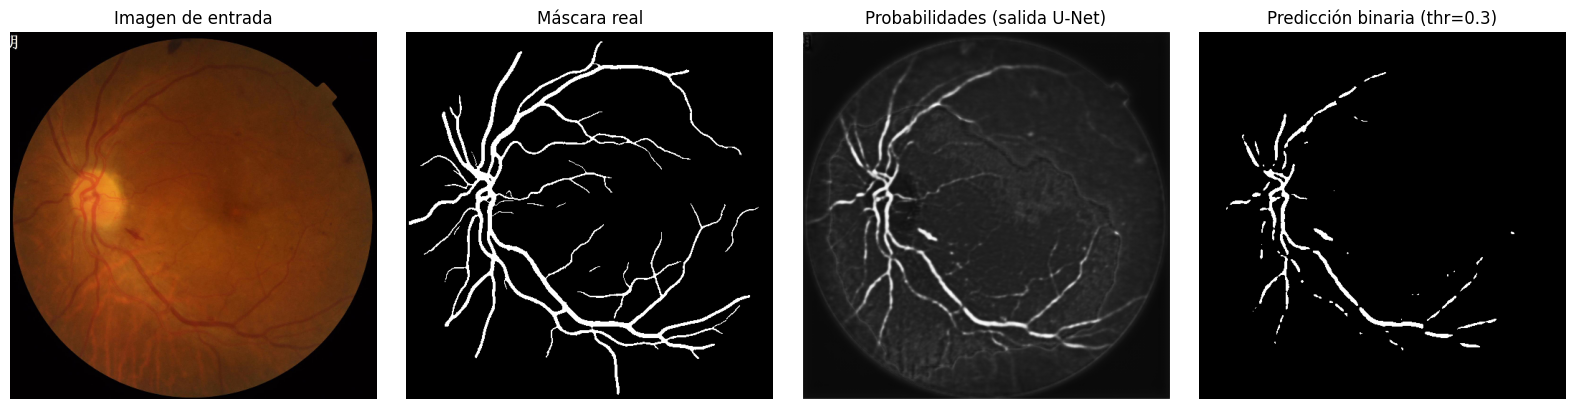

In [ ]:
import matplotlib.pyplot as plt
idx = 0
thr_vis = base_config["threshold"]

probs = model.predict(x_test[idx:idx+1], verbose=0)[0, :, :, 0]
bin_mask = (probs > thr_vis).astype(np.uint8)

plt.figure(figsize=(16, 4))

plt.subplot(1, 4, 1)
plt.imshow(x_test[idx])
plt.title("Imagen de entrada")
plt.axis("off")

plt.subplot(1, 4, 2)
plt.imshow(y_test[idx].squeeze(), cmap="gray")
plt.title("Máscara real")
plt.axis("off")

plt.subplot(1, 4, 3)
plt.imshow(probs, cmap="gray")
plt.title("Probabilidades (salida U-Net)")
plt.axis("off")

plt.subplot(1, 4, 4)
plt.imshow(bin_mask, cmap="gray")
plt.title(f"Predicción binaria (thr={thr_vis})")
plt.axis("off")

plt.tight_layout()
plt.show()